In [1]:
# =====================================
# Block 1: Setup & Imports
# =====================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

np.random.seed(42)
print("✅ Libraries loaded")


✅ Libraries loaded


In [2]:
# =====================================
# Block 2: Generate Synthetic Telemetry (no acquisition)
# =====================================
n_users = 500
months = 24
data = []

for user in range(1, n_users+1):
    user_type = np.random.choice(["heavy", "medium", "light"], p=[0.2, 0.5, 0.3])
    for m in range(months):
        if user_type == "heavy":
            api_calls = np.random.poisson(800)
            seats = np.random.randint(5, 15)
            gb_used = np.random.gamma(10, 5)
            churn_prob = 0.01
        elif user_type == "medium":
            api_calls = np.random.poisson(300)
            seats = np.random.randint(2, 8)
            gb_used = np.random.gamma(5, 3)
            churn_prob = 0.03
        else:  # light
            api_calls = np.random.poisson(100)
            seats = np.random.randint(1, 4)
            gb_used = np.random.gamma(2, 2)
            churn_prob = 0.06

        if np.random.rand() < churn_prob:
            break

        data.append([user, m, user_type, api_calls, seats, gb_used])

telemetry = pd.DataFrame(data, columns=["user_id","month","segment","api_calls","seats_used","gb_used"])
display(telemetry.head(10))


,user_id,month,segment,api_calls,seats_used,gb_used
0,1,0,medium,339,6,7.583675
1,1,1,medium,291,4,32.971482
2,1,2,medium,319,5,10.613914
3,1,3,medium,289,3,8.824601
4,1,4,medium,286,7,14.442209
5,1,5,medium,305,3,6.647730
6,1,6,medium,317,6,9.684926
7,1,7,medium,319,2,9.537130
8,1,8,medium,290,3,11.217257
9,1,9,medium,295,7,14.436447


In [3]:
# =====================================
# Block 3: Pricing Models
# =====================================
def subscription_revenue(row, base_sub=100):
    return base_sub

def usage_revenue(row, base_usage=50, api_price=0.05, seat_price=2.0, gb_price=0.1):
    return base_usage + api_price*row["api_calls"] + seat_price*row["seats_used"] + gb_price*row["gb_used"]

telemetry["sub_revenue"] = telemetry.apply(subscription_revenue, axis=1)
telemetry["usage_revenue"] = telemetry.apply(usage_revenue, axis=1)

display(telemetry.head(10))


,user_id,month,segment,api_calls,seats_used,gb_used,sub_revenue,usage_revenue
0,1,0,medium,339,6,7.583675,100,79.708368
1,1,1,medium,291,4,32.971482,100,75.847148
2,1,2,medium,319,5,10.613914,100,77.011391
3,1,3,medium,289,3,8.824601,100,71.332460
4,1,4,medium,286,7,14.442209,100,79.744221
5,1,5,medium,305,3,6.647730,100,71.914773
6,1,6,medium,317,6,9.684926,100,78.818493
7,1,7,medium,319,2,9.537130,100,70.903713
8,1,8,medium,290,3,11.217257,100,71.621726
9,1,9,medium,295,7,14.436447,100,80.193645


In [4]:
# =====================================
# Block 4: ARR Calculations
# =====================================
arr_baseline = telemetry.groupby("month")["sub_revenue"].sum() * 12
arr_usage = telemetry.groupby("month")["usage_revenue"].sum() * 12

arr_df = pd.DataFrame({
    "Baseline (Subscription)": arr_baseline,
    "Usage-Based": arr_usage
})

uplift = (arr_usage.iloc[-1] - arr_baseline.iloc[-1]) / arr_baseline.iloc[-1] * 100
print("✅ ARR calculated")
display(arr_df.head())


✅ ARR calculated


,Baseline (Subscription),Usage-Based
month,,
0,582000,460763.703714
1,560400,444662.717134
2,543600,434640.339677
3,530400,422978.476721
4,512400,410456.990009


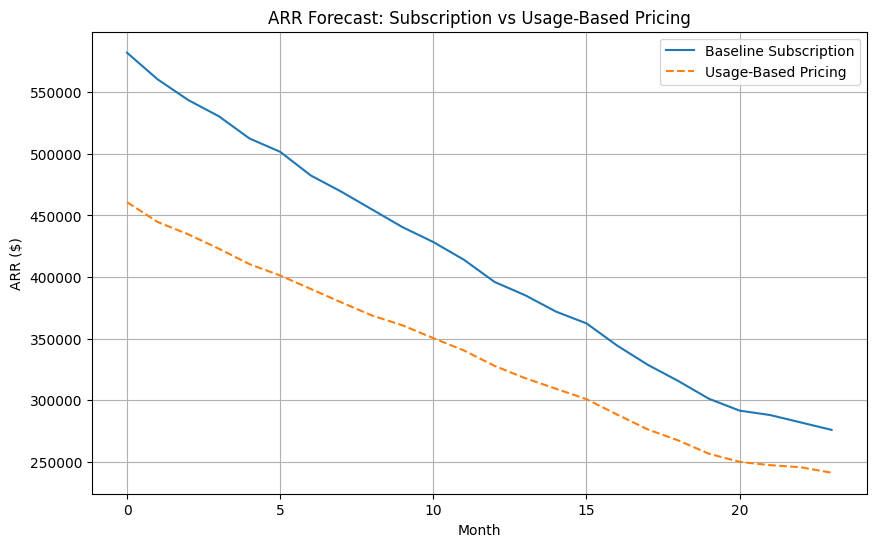

Final Baseline ARR: $276,000
Final Usage-Based ARR: $241,226
Forecasted ARR Uplift: -12.6%


In [5]:
# =====================================
# Block 5: ARR Visualization
# =====================================
plt.figure(figsize=(10,6))
plt.plot(arr_df.index, arr_df["Baseline (Subscription)"], label="Baseline Subscription")
plt.plot(arr_df.index, arr_df["Usage-Based"], label="Usage-Based Pricing", linestyle="--")
plt.title("ARR Forecast: Subscription vs Usage-Based Pricing")
plt.xlabel("Month"); plt.ylabel("ARR ($)")
plt.legend(); plt.grid(True)
plt.show()

print(f"Final Baseline ARR: ${arr_baseline.iloc[-1]:,.0f}")
print(f"Final Usage-Based ARR: ${arr_usage.iloc[-1]:,.0f}")
print(f"Forecasted ARR Uplift: {uplift:.1f}%")


In [6]:
# =====================================
# Block 6: Segment Insights
# =====================================
segment_summary = telemetry.groupby("segment")[["api_calls","seats_used","gb_used","usage_revenue"]].mean().round(1)
print("✅ Segment Insights")
display(segment_summary)


✅ Segment Insights


,api_calls,seats_used,gb_used,usage_revenue
segment,,,,
heavy,800.6,9.5,50.0,114.0
light,100.1,2.0,4.1,59.4
medium,300.3,4.5,15.0,75.5


In [7]:
# =====================================
# Unified Block: Interactive ARR Model (with Acquisition)
# =====================================

def saas_model(heavy_share=0.3, medium_share=0.5, light_share=0.2,
               base_sub=100, base_usage=50,
               api_price=0.05, seat_price=2.0, gb_price=0.1,
               min_commit=0, months=24,
               n_users_start=500, new_users_start=0, growth_rate=0.0):
    """
    SaaS ARR simulator with acquisition toggle.
    - If new_users_start=0, behaves like churn-only model (downward ARR).
    - If new_users_start>0, ARR grows with acquisition.
    """

    np.random.seed(42)
    rows, user_id = [], 0
    shares = np.array([heavy_share, medium_share, light_share], dtype=float)
    shares = shares / shares.sum()

    for m in range(months):
        # initial users at month 0
        if m == 0:
            new_users = n_users_start
        else:
            new_users = int(new_users_start * ((1 + growth_rate) ** m))

        for _ in range(new_users):
            user_id += 1
            seg = np.random.choice(["heavy","medium","light"], p=shares)

            for t in range(m, months):
                if seg == "heavy":
                    api_calls = np.random.poisson(800); seats = np.random.randint(5, 15); gb_used = np.random.gamma(10, 5); churn = 0.01
                elif seg == "medium":
                    api_calls = np.random.poisson(300); seats = np.random.randint(2, 8); gb_used = np.random.gamma(5, 3); churn = 0.03
                else:
                    api_calls = np.random.poisson(100); seats = np.random.randint(1, 4); gb_used = np.random.gamma(2, 2); churn = 0.06

                if np.random.rand() < churn:
                    break

                sub_rev = base_sub
                usage_rev = base_usage + api_price*api_calls + seat_price*seats + gb_price*gb_used
                usage_rev = max(min_commit, usage_rev) if min_commit > 0 else usage_rev
                rows.append([user_id, t, seg, sub_rev, usage_rev])

    df = pd.DataFrame(rows, columns=["user_id","month","segment","sub_revenue","usage_revenue"])
    arr_sub = df.groupby("month")["sub_revenue"].sum() * 12
    arr_use = df.groupby("month")["usage_revenue"].sum() * 12
    uplift = (arr_use.iloc[-1] - arr_sub.iloc[-1]) / arr_sub.iloc[-1] * 100

    # Plot
    plt.figure(figsize=(10,6))
    plt.plot(arr_sub.index, arr_sub, label="Baseline Subscription")
    plt.plot(arr_use.index, arr_use, label="Usage-Based Pricing", linestyle="--")
    plt.title("ARR Forecast: Subscription vs Usage-Based Pricing")
    plt.xlabel("Month"); plt.ylabel("Annual Recurring Revenue ($)")
    plt.legend(); plt.grid(True)
    plt.show()

    # Results
    print(f"Final Baseline ARR: ${arr_sub.iloc[-1]:,.0f}")
    print(f"Final Usage-Based ARR: ${arr_use.iloc[-1]:,.0f}")
    print(f"Forecasted ARR Uplift: {uplift:.1f}%")

# Interactive controls
interact(
    saas_model,
    heavy_share=widgets.FloatSlider(value=0.3, min=0.0, max=1.0, step=0.05, description="Heavy %"),
    medium_share=widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.05, description="Medium %"),
    light_share=widgets.FloatSlider(value=0.2, min=0.0, max=1.0, step=0.05, description="Light %"),
    base_sub=widgets.IntSlider(value=100, min=50, max=200, step=10, description="Flat Sub $"),
    base_usage=widgets.IntSlider(value=50, min=0, max=150, step=10, description="Base Usage $"),
    api_price=widgets.FloatSlider(value=0.05, min=0.01, max=0.2, step=0.01, description="API $/call"),
    seat_price=widgets.FloatSlider(value=2.0, min=0.5, max=5.0, step=0.5, description="Seat $"),
    gb_price=widgets.FloatSlider(value=0.1, min=0.01, max=0.5, step=0.05, description="GB $"),
    min_commit=widgets.IntSlider(value=0, min=0, max=150, step=5, description="Min Commit $"),
    months=widgets.IntSlider(value=24, min=12, max=60, step=6, description="Months"),
    n_users_start=widgets.IntSlider(value=500, min=100, max=2000, step=100, description="Start Users"),
    new_users_start=widgets.IntSlider(value=0, min=0, max=200, step=10, description="New Users/mo"),
    growth_rate=widgets.FloatSlider(value=0.0, min=0.0, max=0.1, step=0.01, description="Growth Rate")
)


interactive(children=(FloatSlider(value=0.3, description='Heavy %', max=1.0, step=0.05), FloatSlider(value=0.5…

<function __main__.saas_model(heavy_share=0.3, medium_share=0.5, light_share=0.2, base_sub=100, base_usage=50, api_price=0.05, seat_price=2.0, gb_price=0.1, min_commit=0, months=24, n_users_start=500, new_users_start=0, growth_rate=0.0)>